<a href="https://colab.research.google.com/github/VSubhash1/Object-Segmentation-using-Mask-R-CNN/blob/main/Object_Segmentation_using_Mask_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Setup and Install Libraries and Download Utilities
!pip install -q cython pycocotools
!pip install -q opencv-python-headless
!pip install -q scikit-learn
!pip install torchvision torch

# --- DOWNLOAD UTILITIES ---
# Clone the detection utility files from PyTorch/vision repo
!git clone https://github.com/pytorch/vision.git
!cp vision/references/detection/utils.py .
!cp vision/references/detection/engine.py .
!cp vision/references/detection/transforms.py .
!cp vision/references/detection/coco_utils.py .
!cp vision/references/detection/coco_eval.py .
!cp vision/references/detection/presets.py .

# --- DOWNLOAD DATASET (PENN-FUDAN) ---
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip -q PennFudanPed.zip -d /content/
# The dataset will be extracted to: /content/PennFudanPed

import torch
import torchvision
import torchvision.transforms as T # Used for functional transforms like to_tensor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils.data import DataLoader, Dataset
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import cv2
import os
from PIL import Image
from engine import train_one_epoch, evaluate
import transforms as L_transforms # Alias for the copied transforms.py

# Custom ToTensor transform compatible with the detection transforms pipeline
# Uses torchvision.transforms.functional.to_tensor internally
class CustomToTensor(object):
    def __call__(self, image, target):
        # Convert PIL Image to tensor using torchvision.transforms.functional
        image = T.functional.to_tensor(image)
        return image, target

# Define a get_transform function using the local transforms.py for object detection
def get_transform(train):
    transforms_list = [CustomToTensor()] # Use the custom ToTensor
    if train:
        transforms_list.append(L_transforms.RandomHorizontalFlip(0.5))
    return L_transforms.Compose(transforms_list)

# Check for GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')

fatal: destination path 'vision' already exists and is not an empty directory.
--2025-11-12 18:07:27--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip.8’

PennFudanPed.zip.8  100%[===================>]  51.23M  28.7MB/s    in 1.8s    

2025-11-12 18:07:29 (28.7 MB/s) - ‘PennFudanPed.zip.8’ saved [53723336/53723336]

replace /content/PennFudanPed/added-object-list.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Using device: cuda


In [2]:
# Cell 2: PennFudan Dataset Class
class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # Load all image files, sorting them to ensure aligned ordering
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # Load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")

        # Note: Mask is a multi-object mask.
        # Each color/value corresponds to a different instance.
        mask = Image.open(mask_path)
        mask = np.array(mask)

        # Instances are encoded as different colors/values.
        # The background is typically 0, so we get unique instance IDs (1, 2, 3...)
        obj_ids = np.unique(mask)
        # First id is the background, so remove it
        obj_ids = obj_ids[1:]

        # Split the mask into individual binary masks for each object
        masks = mask == obj_ids[:, None, None]

        # Get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # Convert everything to torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # There is only one class (pedestrian)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # Suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
# Cell 3: Model Definition
def get_model_instance_segmentation(num_classes):
    # Load a pre-trained model for instance segmentation (Mask R-CNN with ResNet-50-FPN)
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # Replace the box predictor head
    in_features_box = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features_box, num_classes)

    # Replace the mask predictor head
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    return model

# The get_transform function was redefined here, causing a shape mismatch.
# By removing it, the get_transform from Cell 1 will be used, which correctly
# transforms images to [C, H, W] format expected by the model.


In [13]:
# Cell 4: Configuration, Dataset Loading, and Training

# --- CONFIGURATION ---
# The root folder where PennFudanPed was extracted
ROOT_DIR = '/content/PennFudanPed'
# Total number of classes (Background + Pedestrian)
NUM_CLASSES = 2
# Hyperparameters (small dataset, so few epochs are enough)
EPOCHS = 10
LEARNING_RATE = 0.005

# --- DATA PREPARATION ---
# Create Datasets (80/20 split)
full_dataset = PennFudanDataset(ROOT_DIR, transforms=get_transform(train=True))

dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

# Split the dataset
torch.manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Define the data loaders (use the utility files cloned earlier)
train_loader = DataLoader(
    train_dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=lambda x: tuple(zip(*x))
)
val_loader = DataLoader(
    val_dataset, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=lambda x: tuple(zip(*x))
)

# --- MODEL INITIALIZATION ---
model = get_model_instance_segmentation(NUM_CLASSES)
model.to(device)

# --- OPTIMIZER AND SCHEDULER ---
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# --- TRAINING LOOP ---
print("Starting Training...")
for epoch in range(EPOCHS):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    lr_scheduler.step()

    # Note: PennFudan uses custom evaluation metrics, not COCO API, so we skip
    # the complex COCOeval step for simplicity in this example.
    # The training loss is the main indicator of progress.
    print(f"Epoch {epoch+1} finished. Loss will decrease over epochs.")

    # Save the model checkpoint
    torch.save(model.state_dict(), f'mask_rcnn_epoch_{epoch+1}.pth')

print("Training complete!")

Starting Training...


/content/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/68]  eta: 0:00:58  lr: 0.000080  loss: 5.3225 (5.3225)  loss_classifier: 0.5838 (0.5838)  loss_box_reg: 0.3719 (0.3719)  loss_mask: 4.3572 (4.3572)  loss_objectness: 0.0047 (0.0047)  loss_rpn_box_reg: 0.0049 (0.0049)  time: 0.8592  data: 0.2016  max mem: 3463
Epoch: [0]  [10/68]  eta: 0:00:33  lr: 0.000825  loss: 1.7968 (2.8722)  loss_classifier: 0.4211 (0.4170)  loss_box_reg: 0.3463 (0.3277)  loss_mask: 1.0020 (2.1028)  loss_objectness: 0.0120 (0.0173)  loss_rpn_box_reg: 0.0064 (0.0074)  time: 0.5807  data: 0.0260  max mem: 3630
Epoch: [0]  [20/68]  eta: 0:00:27  lr: 0.001571  loss: 0.9854 (1.8573)  loss_classifier: 0.2341 (0.2959)  loss_box_reg: 0.2922 (0.2837)  loss_mask: 0.5981 (1.2551)  loss_objectness: 0.0151 (0.0162)  loss_rpn_box_reg: 0.0056 (0.0064)  time: 0.5588  data: 0.0092  max mem: 3811
Epoch: [0]  [30/68]  eta: 0:00:21  lr: 0.002316  loss: 0.6032 (1.4439)  loss_classifier: 0.1090 (0.2312)  loss_box_reg: 0.2072 (0.2650)  loss_mask: 0.2420 (0.9257)  loss_ob

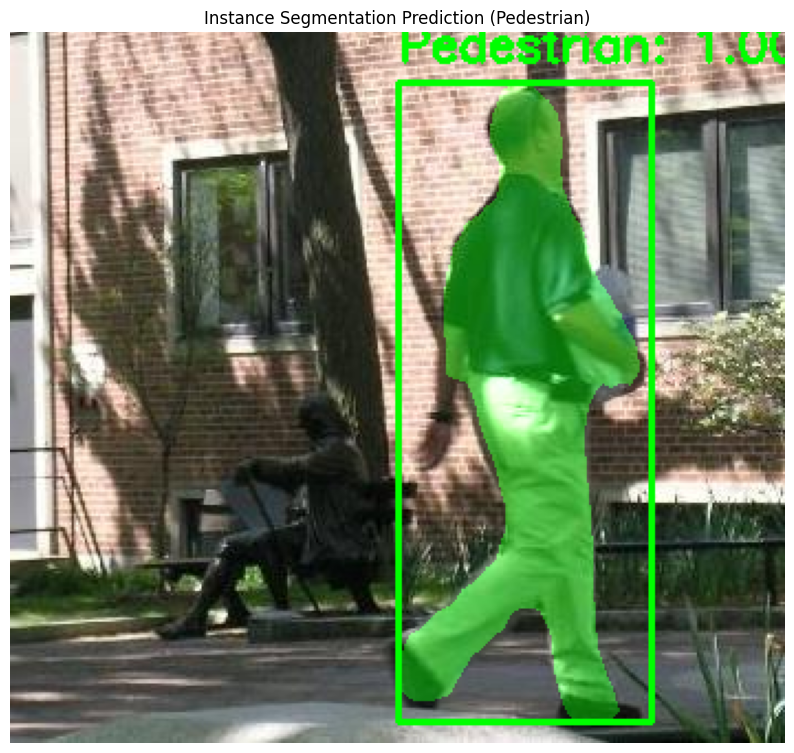

In [15]:
# @title
# Cell 5: Inference and Visualization
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import random

# --- Helper Function for Visualization ---
def visualize_prediction(image_tensor, prediction, class_names=['Background', 'Pedestrian']):
    image = F.to_pil_image(image_tensor.cpu())
    plt.figure(figsize=(10, 10))
    # Convert image back to numpy array for CV2 operations
    image_np = np.array(image)

    # Filter predictions based on a confidence threshold
    score_threshold = 0.7
    masks = prediction[0]['masks'].cpu().squeeze(1)
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()

    # Define a single color for the masks (e.g., green for pedestrians)
    mask_color = (0, 255, 0) # BGR format for OpenCV

    for i in range(len(scores)):
        if scores[i] > score_threshold:
            mask = masks[i]
            label_id = labels[i]

            # Convert mask to numpy array and create an overlay
            mask_np = (mask > 0.5).numpy().astype(np.uint8)

            # Create a green colored mask
            colored_mask = np.zeros_like(image_np)
            colored_mask[mask_np > 0] = mask_color

            # Blend the colored mask with the original image
            image_np = cv2.addWeighted(image_np, 1.0, colored_mask, 0.4, 0)

            # Add label text
            boxes = prediction[0]['boxes'].cpu().numpy()[i]
            label_text = f'{class_names[label_id]}: {scores[i]:.2f}'

            # Draw bounding box
            cv2.rectangle(image_np, (int(boxes[0]), int(boxes[1])), (int(boxes[2]), int(boxes[3])), mask_color, 2)

            # Draw label background
            cv2.putText(image_np, label_text, (int(boxes[0]), int(boxes[1]) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, mask_color, 2)


    plt.imshow(image_np)
    plt.title(f"Instance Segmentation Prediction (Pedestrian)")
    plt.axis('off')
    plt.show()

# --- RUN INFERENCE ---
# Load the best model (e.g., the last one)
# --- RUN INFERENCE ---
# Load the best model (e.g., the last one)
MODEL_PATH = f'mask_rcnn_epoch_{EPOCHS}.pth'
model = get_model_instance_segmentation(NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# Get a random image from the validation set
# img_data is a tuple: (image_tensor, target_dict)
img_data, _ = val_dataset[random.randint(0, len(val_dataset) - 1)]

# 1. Extract the image tensor (which is already C, H, W due to transforms in Cell 1)
img_tensor = img_data.to(device)

# 2. Create the batch: Mask R-CNN expects a list of image tensors
image_list = [img_tensor]

with torch.no_grad():
    # Pass the list containing the single image tensor
    prediction = model(image_list)

# Run Visualization (Note: the visualize_prediction function is expecting the single tensor
# (img_tensor) and the list of predictions (prediction) for internal processing)
visualize_prediction(img_tensor, prediction)


Found 2 images in /content/myimages. Starting inference...

Processing: cityscape-istanbul-turkey-aerial-view.jpg


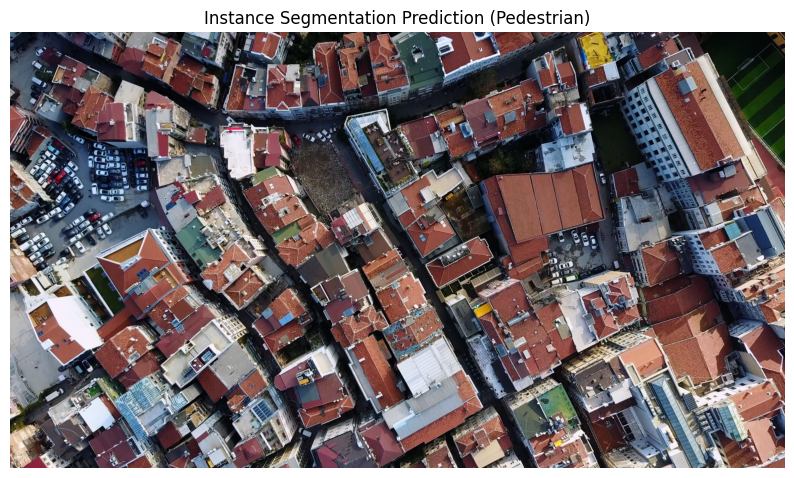


Processing: 2017-04-10-07-10-35.jpg


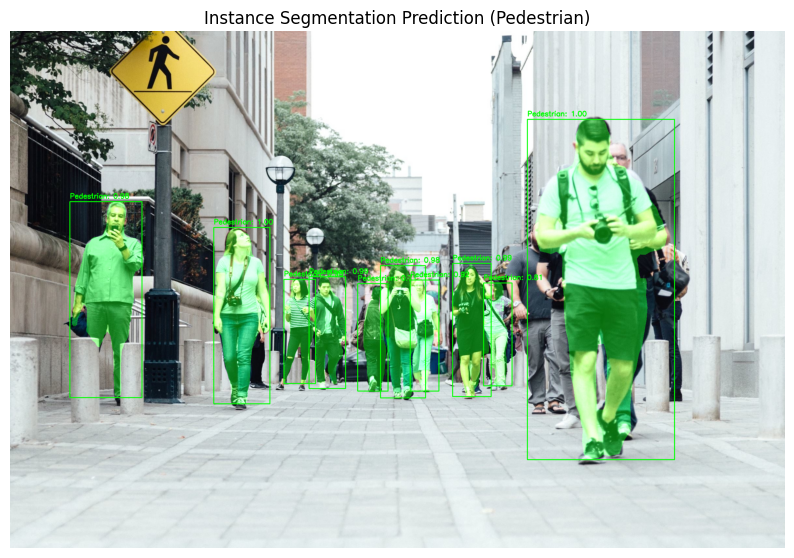

In [20]:
# Cell 5: Inference and Visualization for a CUSTOM FOLDER OF IMAGES

# (Keep the visualize_prediction function exactly as defined in your prompt)
# ...
# --- Helper Function for Visualization (KEEP THIS AS IS) ---
def visualize_prediction(image_tensor, prediction, class_names=['Background', 'Pedestrian']):
    image = F.to_pil_image(image_tensor.cpu())
    plt.figure(figsize=(10, 10))
    # Convert image back to numpy array for CV2 operations
    image_np = np.array(image)

    # Filter predictions based on a confidence threshold
    score_threshold = 0.7
    masks = prediction[0]['masks'].cpu().squeeze(1)
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()

    # Define a single color for the masks (e.g., green for pedestrians)
    mask_color = (0, 255, 0) # BGR format for OpenCV

    for i in range(len(scores)):
        if scores[i] > score_threshold:
            mask = masks[i]
            label_id = labels[i]

            # Convert mask to numpy array and create an overlay
            mask_np = (mask > 0.5).numpy().astype(np.uint8)

            # Create a green colored mask
            colored_mask = np.zeros_like(image_np)
            colored_mask[mask_np > 0] = mask_color

            # Blend the colored mask with the original image
            image_np = cv2.addWeighted(image_np, 1.0, colored_mask, 0.4, 0)

            # Add label text
            boxes = prediction[0]['boxes'].cpu().numpy()[i]
            label_text = f'{class_names[label_id]}: {scores[i]:.2f}'

            # Draw bounding box
            cv2.rectangle(image_np, (int(boxes[0]), int(boxes[1])), (int(boxes[2]), int(boxes[3])), mask_color, 2)

            # Draw label background
            cv2.putText(image_np, label_text, (int(boxes[0]), int(boxes[1]) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, mask_color, 2)


    plt.imshow(image_np)
    plt.title(f"Instance Segmentation Prediction (Pedestrian)")
    plt.axis('off')
    plt.show()

# --- RUN INFERENCE SETUP (Same as before) ---
MODEL_PATH = f'mask_rcnn_epoch_{EPOCHS}.pth'
model = get_model_instance_segmentation(NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# --- CUSTOM FOLDER INFERENCE ---
CUSTOM_TEST_DIR = '/content/myimages'
IMAGE_FILES = [f for f in os.listdir(CUSTOM_TEST_DIR) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Define the inference transformation pipeline
# Use T.functional.to_tensor directly for consistency and to avoid ToDtype error
def transform_inference(img_pil):
    return T.functional.to_tensor(img_pil)

print(f"Found {len(IMAGE_FILES)} images in {CUSTOM_TEST_DIR}. Starting inference...")

# Loop through each image in the custom folder
for file_name in IMAGE_FILES:
    img_path = os.path.join(CUSTOM_TEST_DIR, file_name)
    print(f"\nProcessing: {file_name}")

    try:
        # 1. Load the image using PIL
        custom_img_pil = Image.open(img_path).convert("RGB")

        # 2. Apply transformations: PIL -> Tensor [C, H, W]
        img_tensor_custom = transform_inference(custom_img_pil).to(device)

        # 3. Create the batch: [ [C, H, W] ]
        image_list_custom = [img_tensor_custom]

        # 4. Run Model Inference
        with torch.no_grad():
            prediction_custom = model(image_list_custom)

        # 5. Run Visualization with the custom image
        # Note: The visualize_prediction function is designed to handle this output structure
        visualize_prediction(img_tensor_custom, prediction_custom, class_names=['Background', 'Pedestrian'])

    except Exception as e:
        print(f"Error processing {file_name}: {e}")
        continue # Skip to the next image if one fails
